# Otimiza√ß√£o de Campanha de Sondas - Vers√£o Final Corrigida

**Inclui:**
- Respeito √† parada programada (adi√ß√£o √† dura√ß√£o final)
- Coment√°rios em blocos de texto para explicar passo a passo
- Mant√©m toda a estrutura do notebook final marcado
- Pronto para ser a nova base de refer√™ncia

## Instala√ß√£o de bibliotecas necess√°rias

In [1]:
!pip install pandas numpy pulp matplotlib

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16.4/16.4 MB 71.9 MB/s eta 0:00:00


## Importa√ß√£o de pacotes e carregamento de dados

In [2]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpBinary, LpStatus
import matplotlib.pyplot as plt
from datetime import timedelta

# Carregar bases
df_pocos = pd.read_csv('pocos.csv')
df_sondas = pd.read_csv('sondas.csv')
df_pocos['Data_Inicio'] = pd.to_datetime(df_pocos['Ano_Inicio'].astype(str) + '-' + df_pocos['Mes_Inicio'].astype(str) + '-01')

print('Po√ßos:')
display(df_pocos.head())

print('Sondas:')
display(df_sondas.head())


Po√ßos:


Po√ßo  Profundidade (m)  Press√£o Estimada (PSI)  Ano_Inicio  Mes_Inicio  \
0  P-001              2459                    3860        2026           7   
1  P-002              2095                    6772        2026          11   
2  P-003              1121                    3466        2026           7   
3  P-004              2482                    9231        2026          11   
4  P-005              2687                    3130        2026           8   

   Janela de Perfura√ß√£o (dias) Data_Inicio  
0                           84  2026-07-01  
1                           90  2026-11-01  
2                           92  2026-07-01  
3                          105  2026-11-01  
4                           91  2026-08-01

Sondas:


Sonda       Tipo  Profundidade M√°xima (m)  BOP (PSI M√°x.)  \
0  Sonda-1  Drillship                     1600           10500   
1  Sonda-2       Semi                     1700           11000   
2  Sonda-3  Drillship                     1800           11500   
3  Sonda-4       Semi                     1900           12000   
4  Sonda-5  Drillship                     2000           12500   

  Capacidade Log√≠stica  Custo Opera√ß√£o (USD/dia)  Tempo de Setup (dias)  \
0                M√©dia                    455000                      2   
1                M√©dia                    460000                      2   
2                 Alta                    465000                      2   
3                M√©dia                    470000                      2   
4                M√©dia                    475000                      2   

   Dias de Opera√ß√£o Cont√≠nua  Dias de Parada Programada  
0                         60                          3  
1                         60                          3  
2                         60                          3  
3                         60                          3  
4                         60                          3

## Gera√ß√£o da matriz de compatibilidade
Verifica se a sonda suporta as exig√™ncias t√©cnicas do po√ßo

In [3]:
matriz_compatibilidade = []
for _, po√ßo in df_pocos.iterrows():
    for _, sonda in df_sondas.iterrows():
        compativel = int(
            (sonda['Profundidade M√°xima (m)'] >= po√ßo['Profundidade (m)']) and
            (sonda['BOP (PSI M√°x.)'] >= po√ßo['Press√£o Estimada (PSI)'])
        )
        matriz_compatibilidade.append({'Po√ßo': po√ßo['Po√ßo'], 'Sonda': sonda['Sonda'], 'Compat√≠vel': compativel})
df_compatibilidade = pd.DataFrame(matriz_compatibilidade)

print('Matriz de compatibilidade:')
display(df_compatibilidade.head())

Matriz de compatibilidade:


Po√ßo    Sonda  Compat√≠vel
0  P-001  Sonda-1           0
1  P-001  Sonda-2           0
2  P-001  Sonda-3           0
3  P-001  Sonda-4           0
4  P-001  Sonda-5           0

## Modelagem de otimiza√ß√£o
Minimiza o custo total e garante compatibilidade e aloca√ß√£o √∫nica

In [4]:
modelo = LpProblem('Otimiza√ß√£o_Campanha_Sondas', LpMinimize)
variaveis = {}
for _, po√ßo in df_pocos.iterrows():
    for _, sonda in df_sondas.iterrows():
        chave = (po√ßo['Po√ßo'], sonda['Sonda'])
        variaveis[chave] = LpVariable(f"x_{po√ßo['Po√ßo']}_{sonda['Sonda']}", cat=LpBinary)

# Fun√ß√£o objetivo
modelo += lpSum(
    variaveis[(po√ßo['Po√ßo'], sonda['Sonda'])] * sonda['Custo Opera√ß√£o (USD/dia)']
    for _, po√ßo in df_pocos.iterrows()
    for _, sonda in df_sondas.iterrows()
), 'Custo_Total'

# Restri√ß√µes de compatibilidade e aloca√ß√£o √∫nica
for _, linha in df_compatibilidade.iterrows():
    if linha['Compat√≠vel'] == 0:
        modelo += variaveis[(linha['Po√ßo'], linha['Sonda'])] == 0

for _, po√ßo in df_pocos.iterrows():
    modelo += lpSum(
        variaveis[(po√ßo['Po√ßo'], sonda['Sonda'])] for _, sonda in df_sondas.iterrows()
    ) == 1

## Respeitando as datas e evitando sobreposi√ß√£o

In [5]:
for _, sonda in df_sondas.iterrows():
    for dia in pd.date_range('2026-01-01', '2030-12-31'):
        modelo += lpSum(
            variaveis[(po√ßo['Po√ßo'], sonda['Sonda'])]
            for _, po√ßo in df_pocos.iterrows()
            if (po√ßo['Data_Inicio'] <= dia <= po√ßo['Data_Inicio'] + timedelta(days=int(po√ßo['Janela de Perfura√ß√£o (dias)'])))
        ) <= 1

## Resolu√ß√£o e verifica√ß√£o de status

In [6]:
modelo.solve()
print('Status:', LpStatus[modelo.status])

Status: Optimal


## Ajuste de datas finais com parada programada inclu√≠da

In [7]:
# Construir dataframe de aloca√ß√µes e ajustar datas finais
alocacoes = [(po√ßo, sonda) for (po√ßo, sonda), var in variaveis.items() if var.varValue == 1]
df_alocacoes = pd.DataFrame(alocacoes, columns=['Po√ßo', 'Sonda'])
df_alocacoes = df_alocacoes.merge(df_pocos[['Po√ßo', 'Janela de Perfura√ß√£o (dias)', 'Data_Inicio']], on='Po√ßo', how='left')
df_alocacoes = df_alocacoes.merge(df_sondas[['Sonda', 'Tempo de Setup (dias)', 'Dias de Opera√ß√£o Cont√≠nua', 'Dias de Parada Programada']], on='Sonda', how='left')

# Adiciona parada programada ao tempo total
df_alocacoes['Dura√ß√£o_Total'] = df_alocacoes['Janela de Perfura√ß√£o (dias)'] + df_alocacoes['Dias de Parada Programada']
df_alocacoes['In√≠cio'] = df_alocacoes['Data_Inicio'] + pd.to_timedelta(df_alocacoes['Tempo de Setup (dias)'], unit='D')
df_alocacoes['Fim'] = df_alocacoes['In√≠cio'] + pd.to_timedelta(df_alocacoes['Dura√ß√£o_Total'] - 1, unit='D')

## Visualiza√ß√£o no Gantt e tabela

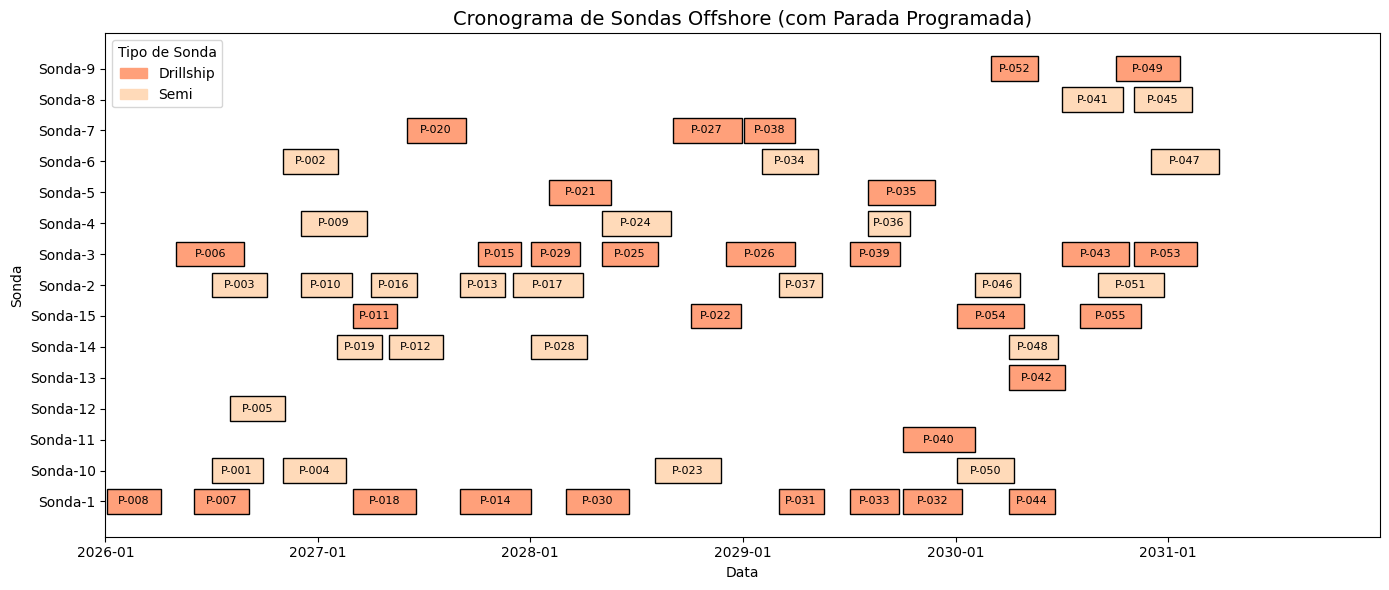

Tabela final ordenada:


Sonda   Po√ßo     In√≠cio        Fim  Dura√ß√£o_Total  Custo_Total_Po√ßo
7    Sonda-1  P-008 2026-01-03 2026-04-06             94          42770000
6    Sonda-1  P-007 2026-06-03 2026-09-03             93          42315000
17   Sonda-1  P-018 2027-03-03 2027-06-18            108          49140000
13   Sonda-1  P-014 2027-09-03 2028-01-02            122          55510000
29   Sonda-1  P-030 2028-03-03 2028-06-17            107          48685000
30   Sonda-1  P-031 2029-03-03 2029-05-18             77          35035000
32   Sonda-1  P-033 2029-07-03 2029-09-24             84          38220000
31   Sonda-1  P-032 2029-10-03 2030-01-10            100          45500000
43   Sonda-1  P-044 2030-04-03 2030-06-20             79          35945000
0   Sonda-10  P-001 2026-07-03 2026-09-27             87          43500000
3   Sonda-10  P-004 2026-11-03 2027-02-18            108          54000000
22  Sonda-10  P-023 2028-08-03 2028-11-22            112          56000000
49  Sonda-10  P-050 2030-01-03 2030-04-11             99          49500000
39  Sonda-11  P-040 2029-10-03 2030-02-02            123          62115000
4   Sonda-12  P-005 2026-08-03 2026-11-04             94          47940000
41  Sonda-13  P-042 2030-04-03 2030-07-06             95          48925000
18  Sonda-14  P-019 2027-02-03 2027-04-21             78          40560000
11  Sonda-14  P-012 2027-05-03 2027-08-03             93          48360000
27  Sonda-14  P-028 2028-01-03 2028-04-07             96          49920000
47  Sonda-14  P-048 2030-04-03 2030-06-24             83          43160000
10  Sonda-15  P-011 2027-03-03 2027-05-16             75          39375000
21  Sonda-15  P-022 2028-10-03 2028-12-27             86          45150000
53  Sonda-15  P-054 2030-01-03 2030-04-28            116          60900000
54  Sonda-15  P-055 2030-08-03 2030-11-14            104          54600000
2    Sonda-2  P-003 2026-07-03 2026-10-05             95          43700000
9    Sonda-2  P-010 2026-12-03 2027-02-27             87          40020000
15   Sonda-2  P-016 2027-04-03 2027-06-20             79          36340000
12   Sonda-2  P-013 2027-09-03 2027-11-17             76          34960000
16   Sonda-2  P-017 2027-12-03 2028-03-30            119          54740000
36   Sonda-2  P-037 2029-03-03 2029-05-16             75          34500000
45   Sonda-2  P-046 2030-02-03 2030-04-21             78          35880000
50   Sonda-2  P-051 2030-09-03 2030-12-24            113          51980000
5    Sonda-3  P-006 2026-05-03 2026-08-26            116          53940000
14   Sonda-3  P-015 2027-10-03 2027-12-15             74          34410000
28   Sonda-3  P-029 2028-01-03 2028-03-25             83          38595000
24   Sonda-3  P-025 2028-05-03 2028-08-07             97          45105000
25   Sonda-3  P-026 2028-12-03 2029-03-29            117          54405000
38   Sonda-3  P-039 2029-07-03 2029-09-27             87          40455000
42   Sonda-3  P-043 2030-07-03 2030-10-25            115          53475000
52   Sonda-3  P-053 2030-11-03 2031-02-19            109          50685000
8    Sonda-4  P-009 2026-12-03 2027-03-26            114          53580000
23   Sonda-4  P-024 2028-05-03 2028-08-29            119          55930000
35   Sonda-4  P-036 2029-08-03 2029-10-14             73          34310000
20   Sonda-5  P-021 2028-02-03 2028-05-18            106          50350000
34   Sonda-5  P-035 2029-08-03 2029-11-26            116          55100000
1    Sonda-6  P-002 2026-11-03 2027-02-03             93          44640000
33   Sonda-6  P-034 2029-02-03 2029-05-08             95          45600000
46   Sonda-6  P-047 2030-12-03 2031-03-28            116          55680000
19   Sonda-7  P-020 2027-06-03 2027-09-11            101          48985000
26   Sonda-7  P-027 2028-09-03 2028-12-28            117          56745000
37   Sonda-7  P-038 2029-01-03 2029-03-29             86          41710000
40   Sonda-8  P-041 2030-07-03 2030-10-14            104          50960000
44   Sonda-8  P-045 2030-11

In [8]:
# Ordenar aloca√ß√µes por sonda e data de in√≠cio
df_alocacoes.sort_values(['Sonda', 'In√≠cio'], inplace=True)

# Calcular o custo total de cada po√ßo
df_alocacoes['Custo_Total_Po√ßo'] = df_alocacoes.apply(
    lambda row: df_sondas.loc[df_sondas['Sonda'] == row['Sonda'], 'Custo Opera√ß√£o (USD/dia)'].values[0] * row['Dura√ß√£o_Total'],
    axis=1
)

# Preparar as cores para os tipos de sonda
cores_sondas = {
    'Drillship': '#FFA07A',  # Laranja claro (salmon claro)
    'Semi': '#FFDAB9'        # Salm√£o claro (peachpuff)
}

# Plotar o gr√°fico Gantt
fig, ax = plt.subplots(figsize=(14, 6))

for i, row in df_alocacoes.iterrows():
    tipo_sonda = df_sondas.loc[df_sondas['Sonda'] == row['Sonda'], 'Tipo'].values[0]
    cor = cores_sondas.get(tipo_sonda, 'grey')
    ax.barh(row['Sonda'], row['Dura√ß√£o_Total'], left=row['In√≠cio'], color=cor, edgecolor='black')
    ax.text(row['In√≠cio'] + timedelta(days=int(row['Dura√ß√£o_Total']//2)),
            row['Sonda'], row['Po√ßo'], ha='center', va='center', color='black', fontsize=8)

# Ajustar o eixo x para mostrar ano e m√™s
ax.set_xlim(pd.to_datetime('2026-01-01'), pd.to_datetime('2031-12-31'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Adicionar legenda manualmente
import matplotlib.patches as mpatches
legenda = [mpatches.Patch(color=cor, label=tipo) for tipo, cor in cores_sondas.items()]
ax.legend(handles=legenda, title='Tipo de Sonda', loc='upper left')

ax.set_xlabel('Data')
ax.set_ylabel('Sonda')
ax.set_title('Cronograma de Sondas Offshore (com Parada Programada)', fontsize=14)
plt.tight_layout()
plt.show()

# Exibir tabela final ordenada com custo
print('Tabela final ordenada:')
display(df_alocacoes[['Sonda', 'Po√ßo', 'In√≠cio', 'Fim', 'Dura√ß√£o_Total', 'Custo_Total_Po√ßo']])


## C√°lculo do custo total da campanha

In [9]:
if LpStatus[modelo.status] == 'Optimal':
    custo_total = sum(
        df_sondas.loc[df_sondas['Sonda'] == row['Sonda'], 'Custo Opera√ß√£o (USD/dia)'].values[0] * row['Dura√ß√£o_Total']
        for _, row in df_alocacoes.iterrows()
    )
    print(f"Custo total da campanha (USD): {custo_total:,.2f}")
else:
    print("N√£o foi poss√≠vel encontrar uma solu√ß√£o √≥tima.")

Custo total da campanha (USD): 2,577,450,000.00


In [10]:
# üìÑ Gerar um PDF com capa, Gantt, tabela e custo total

from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('relatorio_final.pdf') as pdf:
    # üéØ 0Ô∏è‚É£ Capa do relat√≥rio
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    ax.text(0.5, 0.5, "Relat√≥rio de otimiza√ß√£o da campanha de po√ßos offshore",
            ha='center', va='center', fontsize=20, fontweight='bold', color='navy')
    pdf.savefig(fig)
    plt.close()

    # 1Ô∏è‚É£ Plotar Gantt no PDF (convers√£o expl√≠cita de datas!)
    fig, ax = plt.subplots(figsize=(14, 6))
    for i, row in df_alocacoes.iterrows():
        tipo_sonda = df_sondas.loc[df_sondas['Sonda'] == row['Sonda'], 'Tipo'].values[0]
        cor = cores_sondas.get(tipo_sonda, 'grey')

        # Convers√£o de In√≠cio para datetime (se estiver como string)
        inicio_dt = pd.to_datetime(row['In√≠cio'])

        ax.barh(row['Sonda'], row['Dura√ß√£o_Total'], left=inicio_dt, color=cor, edgecolor='black')
        ax.text(inicio_dt + timedelta(days=int(row['Dura√ß√£o_Total']//2)),
                row['Sonda'], row['Po√ßo'], ha='center', va='center', color='black', fontsize=8)

    ax.set_xlim(pd.to_datetime('2026-01-01'), pd.to_datetime('2031-12-31'))
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

    import matplotlib.patches as mpatches
    legenda = [mpatches.Patch(color=cor, label=tipo) for tipo, cor in cores_sondas.items()]
    ax.legend(handles=legenda, title='Tipo de Sonda', loc='upper left')

    ax.set_xlabel('Data')
    ax.set_ylabel('Sonda')
    ax.set_title('Cronograma de Sondas Offshore (com Parada Programada)', fontsize=14)
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()

    # 2Ô∏è‚É£ Ajustar as datas como string **apenas para a tabela final**
    df_alocacoes_copy = df_alocacoes.copy()
    df_alocacoes_copy['In√≠cio'] = pd.to_datetime(df_alocacoes_copy['In√≠cio']).dt.strftime('%Y-%m-%d')
    df_alocacoes_copy['Fim'] = pd.to_datetime(df_alocacoes_copy['Fim']).dt.strftime('%Y-%m-%d')

    # Adicionar a tabela final ordenada no PDF
    from pandas.plotting import table
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    tbl = table(ax, df_alocacoes_copy[['Sonda', 'Po√ßo', 'In√≠cio', 'Fim', 'Dura√ß√£o_Total', 'Custo_Total_Po√ßo']],
                 loc='center', colWidths=[0.13]*6)
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(4)   # Fonte menor
    tbl.scale(0.5, 0.5)   # Reduzir o tamanho da tabela
    ax.set_title('Tabela Final Ordenada', fontsize=12, fontweight='bold')
    pdf.savefig(fig)
    plt.close()

    # 3Ô∏è‚É£ Adicionar o custo total final ao PDF
    if LpStatus[modelo.status] == 'Optimal':
        fig, ax = plt.subplots(figsize=(8, 2))
        ax.axis('off')
        custo_total = sum(
            df_sondas.loc[df_sondas['Sonda'] == row['Sonda'], 'Custo Opera√ß√£o (USD/dia)'].values[0] * row['Dura√ß√£o_Total']
            for _, row in df_alocacoes.iterrows()
        )
        ax.text(0.5, 0.5, f"Custo total da campanha (USD): {custo_total:,.2f}",
                ha='center', va='center', fontsize=14, weight='bold', color='darkgreen')
        pdf.savefig(fig)
        plt.close()
    else:
        fig, ax = plt.subplots(figsize=(8, 2))
        ax.axis('off')
        ax.text(0.5, 0.5, "N√£o foi poss√≠vel encontrar uma solu√ß√£o √≥tima.",
                ha='center', va='center', fontsize=14, color='red')
        pdf.savefig(fig)
        plt.close()

print("PDF gerado com sucesso: relatorio_final.pdf")


PDF gerado com sucesso: relatorio_final.pdf
